In [53]:
from IPython.display import Image, display_png

# 1.このSprintについて

Sprintの目的
* 系列データに関する応用例を学ぶ

どのように学ぶか
* 公開されているコードを元に学んでいきます。

# 2.機械翻訳


系列データに関する手法の基本的な活用例としては機械翻訳があります。これは系列データを入力し、系列データを出力する Sequence to Sequence の手法によって行えます。

## 【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。


[keras/lstm_seq2seq.py at master · keras-team/keras](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py)


その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。


（例）


* 51から55行目 : ライブラリのimport
* 57から62行目 : ハイパーパラメータの設定

《文字単位のトークン化》


この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。


scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。


charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。


sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation

In [2]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2020-10-09 06:19:53--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.24.109.196, 104.24.108.196, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6073837 (5.8M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   5.79M  8.44MB/s    in 0.7s    

2020-10-09 06:19:54 (8.44 MB/s) - ‘fra-eng.zip’ saved [6073837/6073837]



In [3]:
!unzip fra-eng.zip

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [4]:

from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = './fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 2s 18ms/step - loss: 1.1808 - accuracy: 0.7252 - val_loss: 1.0485 - val_accuracy: 0.7008
Epoch 2/100
125/125 [==============================] - 2s 13ms/step - loss: 0.8554 - accuracy: 0.7691 - val_loss: 0.8380 - val_accuracy: 0.7690
Epoch 3/100
125/125 [==============================] - 2s 13ms/step - loss: 0.6811 - accuracy: 0.8074 - val_loss: 0.7140 - val_accuracy: 0.7955
Epoch 4/100
125/125 [==============================] - 2s 13ms/step - loss: 0.5922 - accuracy: 0.8288 - val_loss: 0.6579 - val_accuracy: 0.8074
Epoch 5/100
125/125 [==============================] - 2s 13ms/step - loss: 0.5415 - accuracy: 0.8421 - val_loss: 0.6084 - val_accuracy: 0.8189
Epoch 6/100
125/125 [==============================] - 2s 13ms/step - loss: 0.5043 - accuracy: 0.8522 - val_loss: 0

* 52から56行目 : ライブラリのimport
* 58から63行目 : ハイパーパラメータの設定
* 66から84行目 : ファイルの読込、inputとtaegetの作成。文字1個ずつリストに格納
* 86から97行目 : 文字セットのソート。文字セットの種類数のセット。一番長い文章数のセット。

* 117から149行目 :

モデル構築していいる モデルはDenseとLSTMのみで構築されている エンコーダ部分とデコーダ部分を分けて作成している デコーダの入力にエンコーダの出力を反映させている

* 160から171 行目 :

predict用のモデルを構築している エンコーダ部分は学習時に使用したものを用いている デコーダ部分はハイパーパラメータで設定した次元数を元に作成している

* 181から216 行目 :

predictする関数 エンコーダとデコーダを分けて実行して推定している。

# 3.イメージキャプショニング

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。


[pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)


イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。



## 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。

データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。

注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [39]:
pwd

'/content/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [35]:
#!git clone https://github.com/pdollar/coco.git
#!cd coco/PythonAPI/
#!make
#!python setup.py build
#!python setup.py install
#cd ../../
#!git clone https://github.com/yunjey/pytorch-tutorial.git
#cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

In [40]:
!wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0

--2020-10-09 06:36:49--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ne0ixz5d58ccbbz/pretrained_model.zip [following]
--2020-10-09 06:36:49--  https://www.dropbox.com/s/raw/ne0ixz5d58ccbbz/pretrained_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc67895ffa25aaa4f92a43ed43c8.dl.dropboxusercontent.com/cd/0/inline/BA42sD-ZcmhCJOJiz7pOpfSBMh0tRFfudn-bnpBHUTQq6uLUSe5s-Twa4ASz-ljYGASnVMg2OeaK2Wn1bumLyRgM2if5xWpeqvAvzpgokjOvH9MUGzoQ_3wfmm8OQH3qze0/file# [following]
--2020-10-09 06:36:50--  https://uc67895ffa25aaa4f92a43ed43c8.dl.dropboxusercontent.com/cd/0/inline/BA42sD-ZcmhCJOJiz7pOpfSBMh0tRFfudn-bnpBHUTQq6uLUSe5s-Twa4ASz-ljYGASnVMg2OeaK2Wn1bumLy

In [41]:
!wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0

--2020-10-09 06:37:28--  https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/26adb7y9m98uisa/vocap.zip [following]
--2020-10-09 06:37:28--  https://www.dropbox.com/s/raw/26adb7y9m98uisa/vocap.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc81a09c29a2fca0f69a289d28b4.dl.dropboxusercontent.com/cd/0/inline/BA6ZFnBPpzFVqWue66urhFSfKN45rG4bL5iKYIP2NgzzfVVEZEeXQW4xt9Gu7AMiIAPxMUfgc8ptJIe7bGiEmF2b0PkgKNqLn4NJ8OMvikS0y1nngOswA6kNwu5KvNstux8/file# [following]
--2020-10-09 06:37:28--  https://uc81a09c29a2fca0f69a289d28b4.dl.dropboxusercontent.com/cd/0/inline/BA6ZFnBPpzFVqWue66urhFSfKN45rG4bL5iKYIP2NgzzfVVEZEeXQW4xt9Gu7AMiIAPxMUfgc8ptJIe7bGiEmF2b0PkgKNqLn4NJ8OMvikS0y1nngOswA6

In [43]:
#!unzip pretrained_model.zip?dl=0

Archive:  pretrained_model.zip?dl=0
  inflating: encoder-5-3000.pkl      
  inflating: decoder-5-3000.pkl      


In [ ]:
#!unzip vocap.zip?dl=0

In [49]:
!python sample.py --image='png/example.png'

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
100% 230M/230M [00:05<00:00, 47.2MB/s]
<start> a group of giraffes standing next to each other . <end>


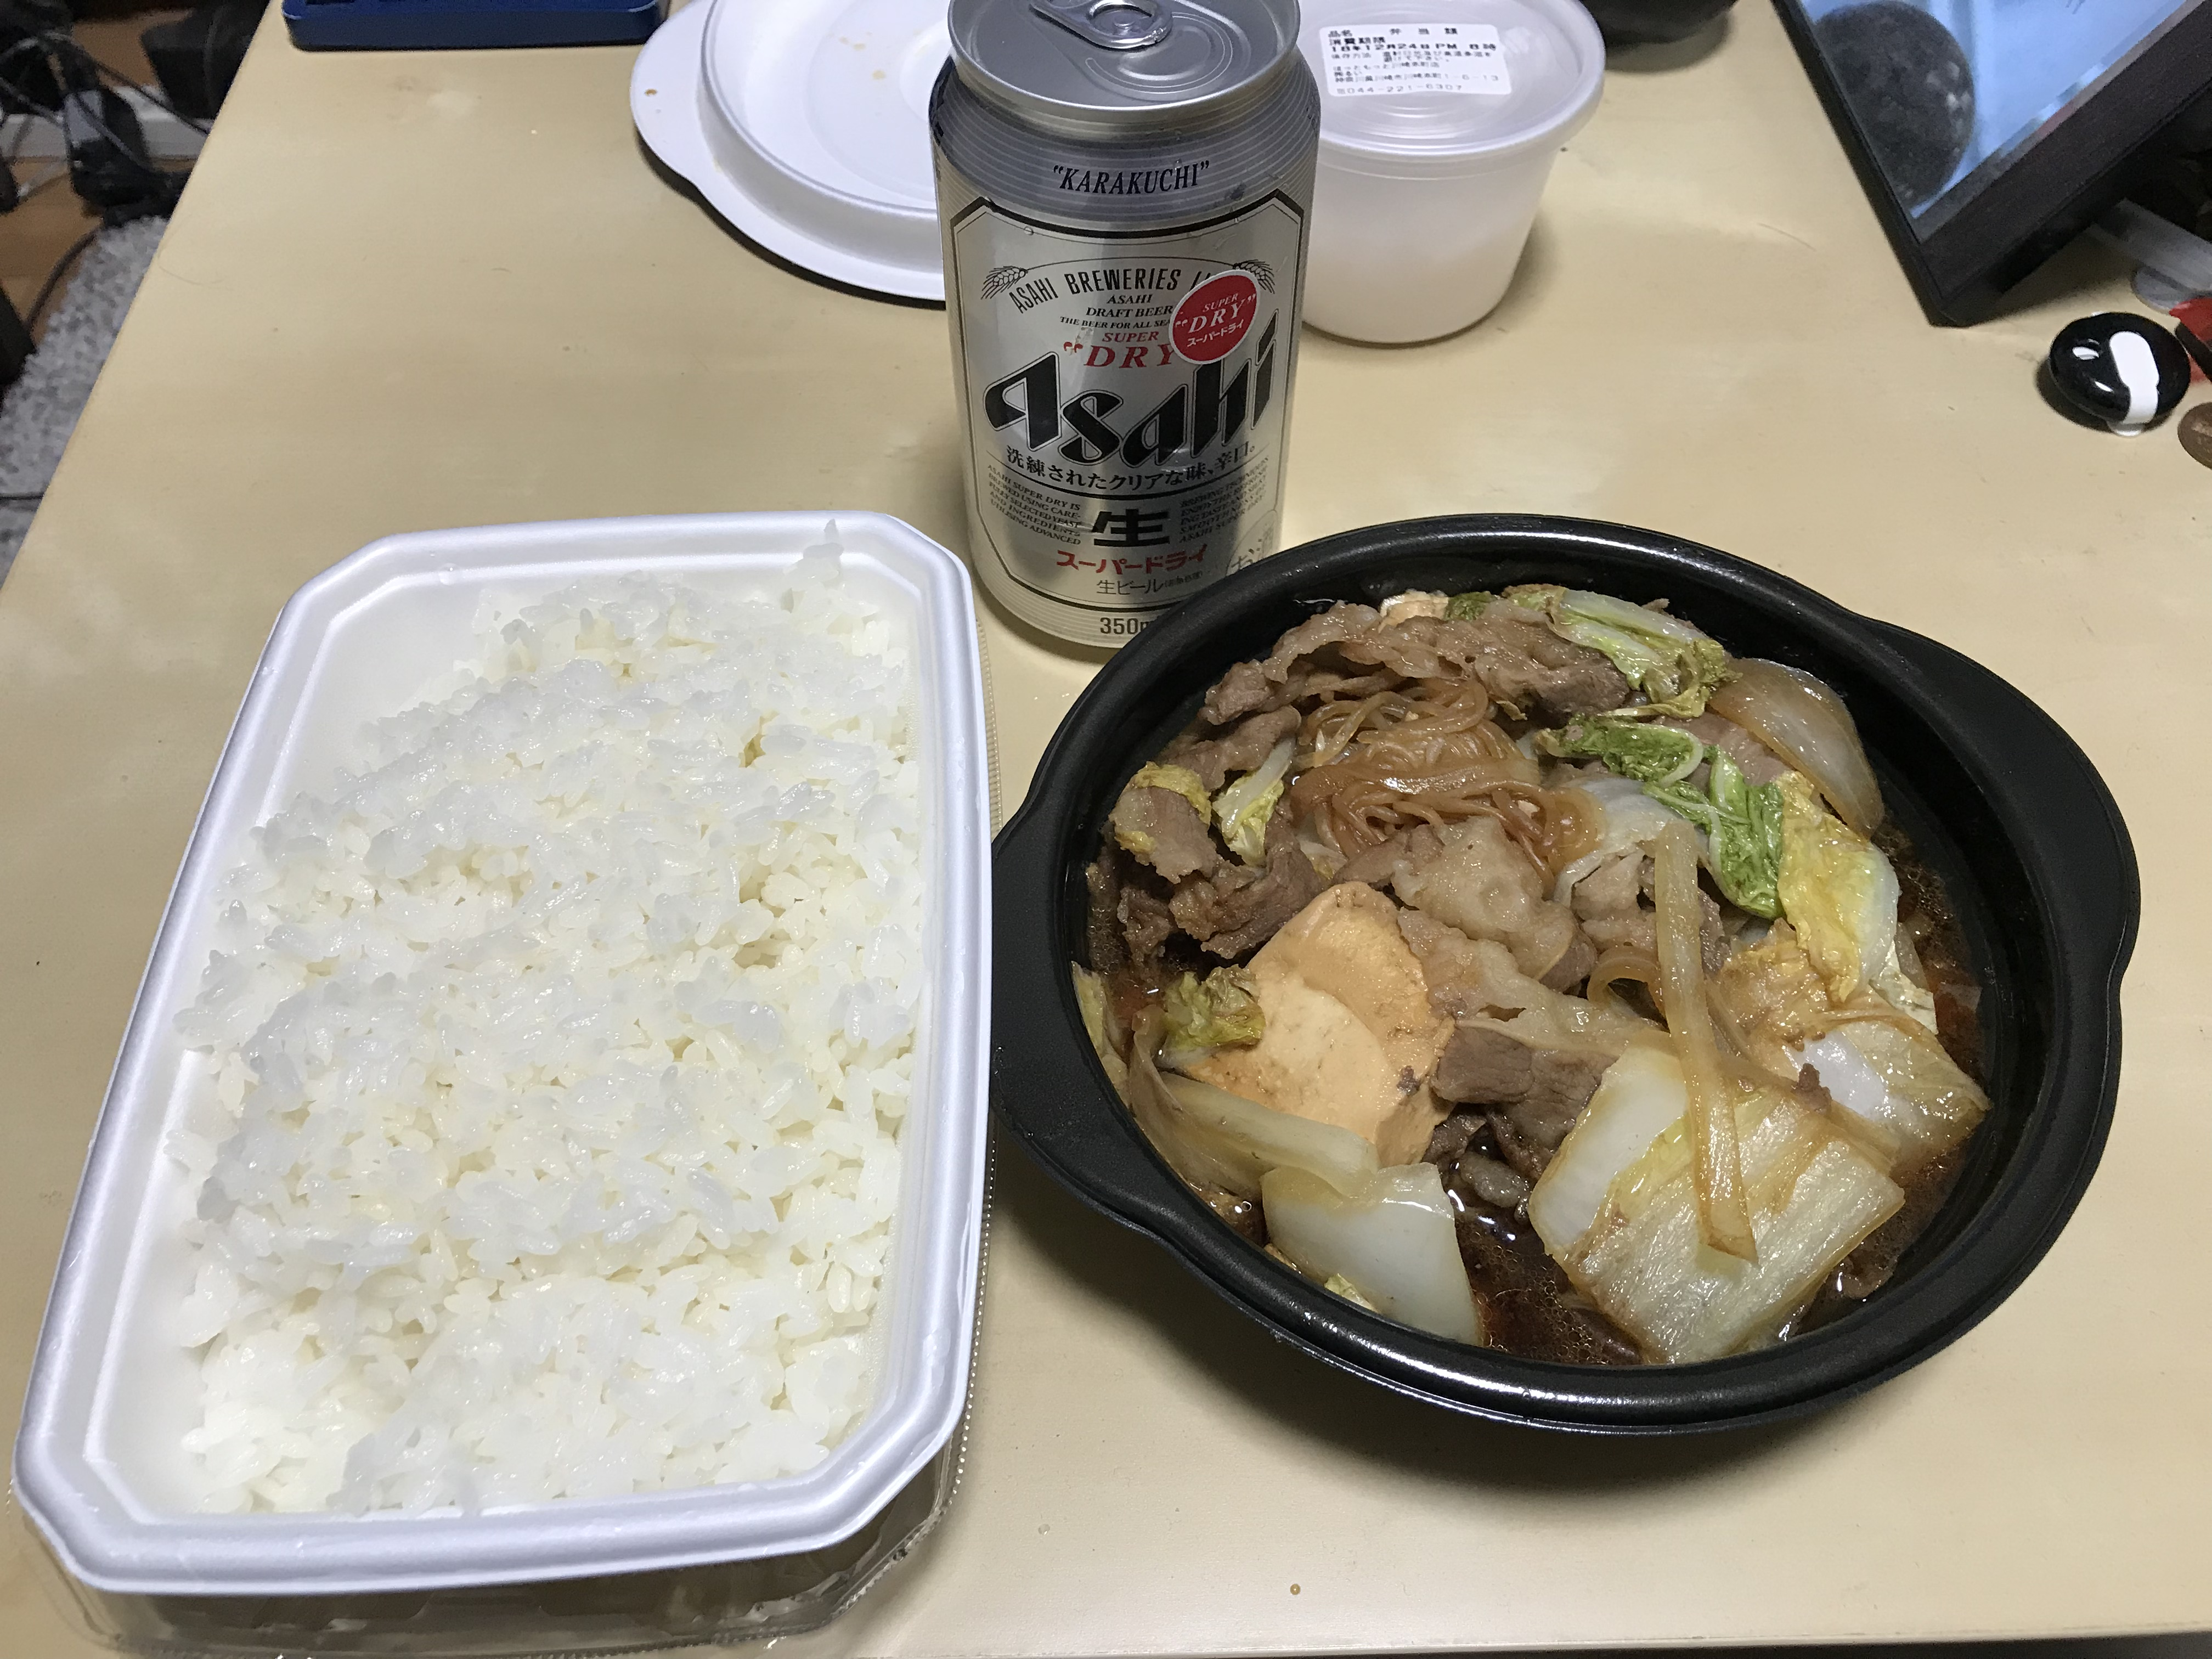

In [58]:
Image(data="/content/pytorch-tutorial/tutorials/03-advanced/image_captioning/png/IMG_0526.JPG", width=300, height=300)

In [61]:
!python sample.py --image="png/IMG_0526.JPG"

<start> a plate of food with a fork and a fork . <end>


## 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

## 【問題3】

* 答え  
  ONNX形式を介してKerasで利用できるようにする
  ONNはOpen Neural Network eXchangeの略。  
  DeepLearningモデルを様々なフレームワーク間で交換するためのフォーマット  
  ちなみにONNXは「オニキス」と発音します


* 手順
  1. Pytorchで学習したモデルをONNX形式に変換して保存する
  2. ONNX形式のモデルをKerasモデルに変換する
  3. Kerasのモデルを, channel_first形式からchannel_last形式に変換する
  4. Kerasのモデルをsaved_model.pbとして保存する

* 解説
  * 全てのフレームワークで相互変換が可能なわけではない

* 参考
  * 公式のGithub  
  https://github.com/onnx/tutorials


|フレームワーク|Importer|Exporter|
|--------------|---------|---------|
|Caffe|	×|	×|
|TensorFlow（※1）|	○|	△|
|MXNet|△	|×|
|CNTK	|○|	○|
|Chainer|	△|	○|
|PyTorch|	×|	○|
|Caffe2（※2）|	○|	○|

○：サポート、△：一部サポート（Experimental）、×：未対応


## 【問題4】（アドバンス課題）コードリーディングと書き換え
モデル部分はmodel.pyに書かれていますが、Kerasではこのモデルがどのように記述できるかを考え、コーディングしてください。その際機械翻訳のサンプルコードが参考になります。

In [65]:
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout, Conv2D
from keras.callbacks import EarlyStopping

In [ ]:
encorder_inputs = Input(shape=(None, ))

## 【問題5】（アドバンス課題）発展的調査
《他の言語の翻訳を行う場合は？》


問題1の実装を使い日本語と英語の翻訳を行いたい場合はどのような手順を踏むか考えてみましょう。


《機械翻訳の発展的手法にはどのようなものがある？》


機械翻訳のための発展的手法にはどういったものがあるか調査してみましょう。


《文章から画像生成するには？》


イメージキャプショニングとは逆に文章から画像を生成する手法もあります。どういったものがあるか調査してみましょう。

In [83]:
with open("fra.txt", "r") as f:
  i = 0
  for r in f:
    print(r)
    i += 1
    if i==30:
      break

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)

Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)

Hi.	Salut.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)

Run!	Cours !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)

Run!	Courez !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)

Who?	Qui ?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #4366796 (gillux)

Wow!	Ça alors !	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #374631 (zmoo)

Fire!	Au feu !	CC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #4627939 (sacredceltic)

Help!	À l'aide !	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #128430 (sysko)

Jump.	Saute.	CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #2416938 (Micsmithel)

Stop!	Ça suffit !	CC-BY 2.0 (France) Attr

In [74]:

from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = './fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

You're welcome.
	Avec plaisir.



In [84]:

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

print(input_token_index)
print(target_token_index)

{' ': 0, '!': 1, '$': 2, '%': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '0': 9, '1': 10, '2': 11, '3': 12, '5': 13, '6': 14, '7': 15, '8': 16, '9': 17, ':': 18, '?': 19, 'A': 20, 'B': 21, 'C': 22, 'D': 23, 'E': 24, 'F': 25, 'G': 26, 'H': 27, 'I': 28, 'J': 29, 'K': 30, 'L': 31, 'M': 32, 'N': 33, 'O': 34, 'P': 35, 'Q': 36, 'R': 37, 'S': 38, 'T': 39, 'U': 40, 'V': 41, 'W': 42, 'Y': 43, 'a': 44, 'b': 45, 'c': 46, 'd': 47, 'e': 48, 'f': 49, 'g': 50, 'h': 51, 'i': 52, 'j': 53, 'k': 54, 'l': 55, 'm': 56, 'n': 57, 'o': 58, 'p': 59, 'q': 60, 'r': 61, 's': 62, 't': 63, 'u': 64, 'v': 65, 'w': 66, 'x': 67, 'y': 68, 'z': 69, 'é': 70}
{'\t': 0, '\n': 1, ' ': 2, '!': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, ',': 10, '-': 11, '.': 12, '0': 13, '1': 14, '2': 15, '3': 16, '5': 17, '8': 18, '9': 19, ':': 20, '?': 21, 'A': 22, 'B': 23, 'C': 24, 'D': 25, 'E': 26, 'F': 27, 'G': 28, 'H': 29, 'I': 30, 'J': 31, 'K': 32, 'L': 33, 'M': 34, 'N': 35, 'O': 36, 'P': 37, 'Q': 38, 'R': 39, 'S': 40, 'T': 41,

In [102]:


encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')


for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

np.set_printoptions(edgeitems=50)
print(input_texts[3])
print(encoder_input_data[2,:,:])

Run!
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [108]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

#テスト
tmp = Model(encoder_inputs, encoder_outputs)
tmp.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None, 71)]        0         
_________________________________________________________________
lstm_9 (LSTM)                [(None, 256), (None, 256) 335872    
Total params: 335,872
Trainable params: 335,872
Non-trainable params: 0
_________________________________________________________________


In [120]:
encoder_states[0]

<tf.Tensor 'lstm_9/PartitionedCall:2' shape=(None, 256) dtype=float32>

In [ ]:


# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)